In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные и посмотрим общую статистику по ним

In [17]:
train = pd.read_csv("data/titanic_train.csv")
test = pd.read_csv("data/titanic_test.csv")

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [20]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Graham, Mr. George Edward",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Перед началом анализа можно сделать предположения относительно зависимости целевой переменной от некоторых признаков. Например, что шансов выжить у женщин, молодых людей (до 30) и пассажиров 1 класса было больше. Построим графики соотношений этих переменных и целевой

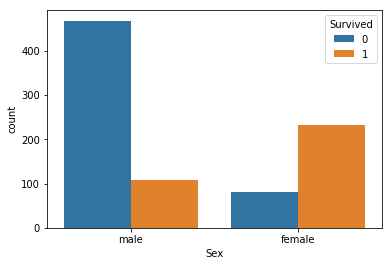

In [21]:
sns.countplot(x="Sex", hue="Survived", data=train)

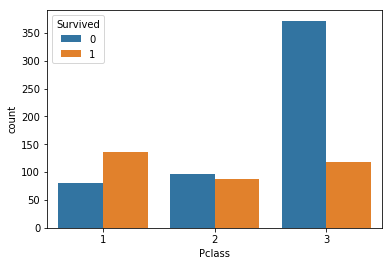

In [22]:
sns.countplot(x="Pclass", hue="Survived", data=train)

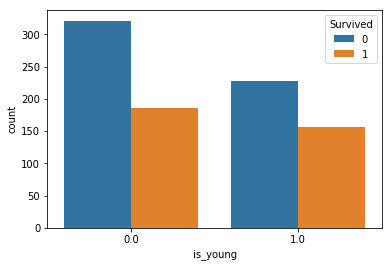

In [23]:
train.loc[train["Age"]<30, "is_young"] = 1
train["is_young"].fillna(0,inplace=True)
sns.countplot(x="is_young", hue="Survived", data=train)

In [24]:
test.loc[test["Age"]<30, "is_young"] = 1
test["is_young"].fillna(0,inplace=True)

Посмотрим, зависит ли целевая переменная от того, путешествовал человек в одиночку или с семьей

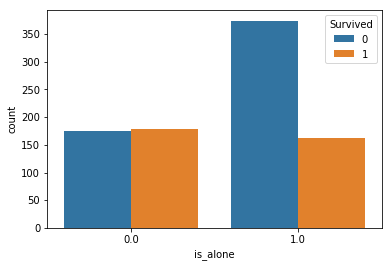

In [25]:
train["Total_rel"] = train[["SibSp","Parch"]].sum(axis=1)
train.loc[train["Total_rel"]==0, "is_alone"] = 1
train["is_alone"].fillna(0,inplace=True)

sns.countplot(x="is_alone", hue="Survived", data=train)

In [41]:
test["Total_rel"] = test[["SibSp","Parch"]].sum(axis=1)
test.loc[test["Total_rel"]==0, "is_alone"] = 1
test["is_alone"].fillna(0,inplace=True)

Определим несколько функций, которые понадобятся для анализа и предсказания

In [27]:
# заполняем пропущенные значения

def process_missing(df):
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

In [28]:
# преобразуем признаки Age, Fare, Cabin в категориальные. Также получим новый категориальный признак Titles из столбца Name

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

In [29]:
# One Hot Encoding для категориальных признаков

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Применим определенные выше функции к обучающей и тестовой выборке

In [30]:
for f in [process_missing, process_age, process_fare, process_titles, process_cabin]:
    train = f(train)
    test = f(test)

In [31]:
for c in ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]:
    train = create_dummies(train, c)
    test = create_dummies(test, c)

In [32]:
from sklearn.feature_selection import RFECV 
from sklearn.ensemble import RandomForestClassifier

In [33]:
# среди числовых признаков выберем наиболее значимые с помощью RFECV

def select_features(df):
    all_X = df.drop(['PassengerId', 'Survived', 'Name', 'Sex',
                     'Ticket', 'Embarked', 'Age_categories', 'Fare_categories',
                    'Title', 'Cabin_type'], axis=1)
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    print optimized_columns
    return optimized_columns

In [34]:
opt_columns = select_features(train)

Index([u'Pclass', u'Age', u'SibSp', u'Parch', u'Fare', u'is_young',
       u'Total_rel', u'is_alone', u'Age_categories_Missing',
       u'Age_categories_Infant', u'Age_categories_Young Adult',
       u'Age_categories_Adult', u'Fare_categories_0-12',
       u'Fare_categories_12-50', u'Title_Miss', u'Title_Mr', u'Title_Mrs',
       u'Cabin_type_C', u'Cabin_type_D', u'Cabin_type_E',
       u'Cabin_type_Unknown', u'Sex_female', u'Sex_male'],
      dtype='object')


C:\Users\User\Anaconda2\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [38]:
# для выбранных признаков и 3х классификаторов - логистической регрессии, knn, случайного леса проведем подбор гиперпараметров

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    model_list = list()
    
    model_list.append({
    "name": "LogisticRegression",
    "estimator": LogisticRegression(),
    "params":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }
    })
    
    model_list.append({
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "params":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
    })
    
    model_list.append({
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "params":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    })
    
    for model in model_list:
        
        grid_cv = GridSearchCV(model["estimator"], model["params"], cv = 10)
        grid_cv.fit(all_X, all_y)
        model["best_params"] = grid_cv.best_params_
        model["best_score"] = grid_cv.best_score_
        model["best_estimator"] = grid_cv.best_estimator_
        
        print model["name"], model["best_score"]
        print model["best_params"]
        print ' '
    
    return model_list

In [39]:
ml = select_model(train, opt_columns)

LogisticRegression 0.8181818181818182
{'solver': 'lbfgs'}
 
KNeighborsClassifier 0.7800224466891134
{'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 1}
 
RandomForestClassifier 0.8395061728395061
{'min_samples_leaf': 1, 'n_estimators': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10}
 


Лучший score показал RandomForestClassifier, с его помощью сделаем предсказание для тестовой выборки и запишем результат в файл

In [42]:
model = ml['name'=='RandomForestClassifier']["best_estimator"]
test_predictions = model.predict(test[opt_columns])
test_ids = test["PassengerId"]
submission_df = {"PassengerId": test_ids, "Survived": test_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv", index=False)

Полученный таким образом kaggle score = 0.77033 лучше предыдущих моих результатов с теми же моделями, но без настройки параметров